## Old inference

In [2]:
from math import exp
import torch
import torch.nn as nn
import torch.optim.lr_scheduler as lr_scheduler
import numpy as np
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import os
import time
from sklearn.preprocessing import MinMaxScaler
import warnings
import random
import pickle


def infer(model_name, op_size):
    dino_s = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')

    transform = T.Compose([
        T.ToTensor()
    ])

    scaler = MinMaxScaler()
    try:
        with open('/cs/home/akhkr1/Documents/scaler.pkl', 'rb') as file:
            #min_max_np = pickle.load(file)
            scaler = pickle.load(file)
    except IOError:
        print('error')
    #scaler.fit(min_max_np)

    class DepthEstimationModel(nn.Module):
        def __init__(self):
            super(DepthEstimationModel, self).__init__()
            self.fc_layers = nn.Sequential(
                nn.Linear(257*384, 1024*2),
                nn.Softplus(),
                nn.Linear(1024*2, 1024*2),
                nn.Softplus(),
                nn.Linear(1024*2, op_size*op_size),
                nn.Softplus()
            )

        def forward(self, x):
            x = x.view(x.size(0), -1)
            x = self.fc_layers(x)  # Passing through the fully connected layers
            x = x.view(x.size(0), op_size, op_size)
            return x

    #scale_the_input()

    model = DepthEstimationModel()
    model.load_state_dict(torch.load(f'/cs/home/akhkr1/Documents/{model_name}/syn_model.pt'))
    model.eval()

infer('500_epochs_downsize', 32)

Using cache found in /home/akhkr1/.cache/torch/hub/facebookresearch_dinov2_main


In [18]:
from skimage.metrics import structural_similarity as ssim


def ssim_loss(depth_pred, depth_gt):
    depth_gt_np = depth_gt.detach().numpy()
    depth_pred_np = depth_pred.detach().numpy()
    ssim_loss = (1.0 - ssim(depth_gt_np, depth_pred_np, data_range = depth_pred_np.max() - depth_pred_np.min()))
    return ssim_loss

class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        self.mseLoss = torch.nn.MSELoss()

    def forward(self, depth_pred, depth_gt):
        mse_loss = self.mseLoss(depth_pred, depth_gt)
        ssim_loss_value = torch.tensor(ssim_loss(depth_pred, depth_gt), dtype=torch.float32)

        total_loss = mse_loss * exp(ssim_loss_value)

        return total_loss

In [19]:

%%time
start = time.time()
rgb_image = Image.open('/cs/home/akhkr1/Documents/test_data/test_input/test_input_frame.0000.color.jpg').resize((224,224))
rgb = transform(rgb_image).unsqueeze(0)
with torch.no_grad():
    dino_features = dino_s.forward_features(rgb)

patch_tokens = dino_features['x_norm_patchtokens']
cls_tokens = dino_features['x_norm_clstoken']
concat = torch.cat((cls_tokens.unsqueeze(0), patch_tokens),dim=1).squeeze(0)        

concat_norm = scaler.transform(concat)
        
concat_norm = torch.tensor(concat_norm,dtype=torch.float32).unsqueeze(0)
        
predicted_depth = model(concat_norm).squeeze(0)
end = time.time()
total = end - start
total


CPU times: user 320 ms, sys: 0 ns, total: 320 ms
Wall time: 60.8 ms


/cs/home/akhkr1/Documents/pytorchvenv/lib64/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/cs/home/akhkr1/Documents/pytorchvenv/lib64/python3.9/site-packages/torch/nn/functional.py:3679: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(


0.06075334548950195

In [12]:
%%time
criterion = CustomLoss()
start = time.time()

#rgb_image = Image.open('r.ppm').resize((224,224))
rgb_real_size = Image.open('/cs/home/akhkr1/Documents/test_data/test_input/test_input_frame.0002.color.jpg').resize((480,480))
rgb_image = Image.open('/cs/home/akhkr1/Documents/test_data/test_input/test_input_frame.0002.color.jpg').resize((224,224))
gt_depth_image = Image.open('/cs/home/akhkr1/Documents/test_data/test_target/test_target_frame.0002.depth_meters.png').convert('L').resize((32,32))
        
rgb = transform(rgb_image).unsqueeze(0)

with torch.no_grad():
    dino_features = dino_s.forward_features(rgb)

patch_tokens = dino_features['x_norm_patchtokens']
cls_tokens = dino_features['x_norm_clstoken']
concat = torch.cat((cls_tokens.unsqueeze(0), patch_tokens),dim=1).squeeze(0)        

concat_norm = scaler.transform(concat)
        
concat_norm = torch.tensor(concat_norm,dtype=torch.float32).unsqueeze(0)
        
predicted_depth = model(concat_norm).squeeze(0)

end = time.time()
total_time = end - start
        
gt_np = np.array(gt_depth_image).astype(np.float32)
gt = torch.tensor(gt_np)
print(predicted_depth.shape)
print('pred: ',predicted_depth.detach().numpy().astype('uint8'))

gt_tensor = torch.tensor(gt)
print('gt: ',gt_tensor.detach().numpy().astype('uint8'))
loss = criterion(predicted_depth, gt_tensor)
print(total_time)
print(loss)


torch.Size([32, 32])
pred:  [[ 41  38  36 ...  51  59  64]
 [ 48  50  45 ...  55  59  68]
 [ 60  64  63 ...  57  64  74]
 ...
 [ 99 100  97 ... 109 110 104]
 [ 91  89  90 ... 106 106 106]
 [ 88  88  87 ... 105 106 106]]
gt:  [[ 44  43  42 ...  71  73  76]
 [ 56  55  54 ...  82  84  86]
 [ 69  68  67 ...  92  96  98]
 ...
 [118 115 112 ...  96  92  87]
 [110 107 105 ...  91  91  90]
 [104 101  99 ...  86  87  88]]
0.08175849914550781
tensor(1973.1328, grad_fn=<MulBackward0>)
CPU times: user 327 ms, sys: 1.2 ms, total: 328 ms
Wall time: 82.9 ms


/cs/home/akhkr1/Documents/pytorchvenv/lib64/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/cs/home/akhkr1/Documents/pytorchvenv/lib64/python3.9/site-packages/torch/nn/functional.py:3679: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(
<timed exec>:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.t

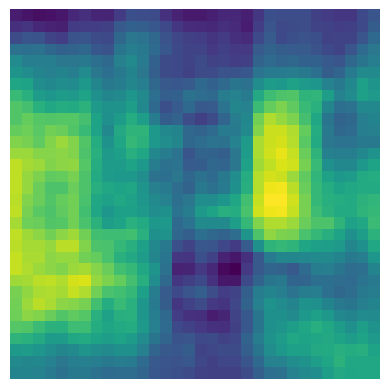

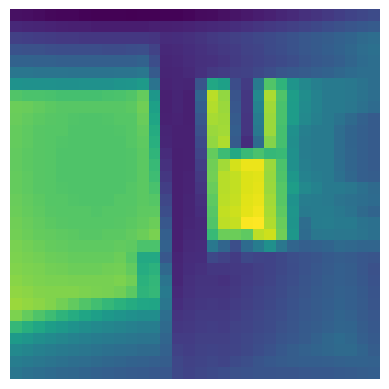

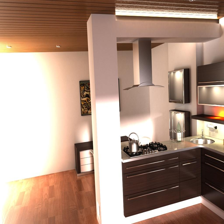

In [13]:
import numpy as np
              
i_output = predicted_depth.detach().cpu().numpy().astype('uint8')
i_depth = Image.fromarray(i_output)
plt.imshow(i_depth)
plt.axis('off')  # Hide the axes
plt.show()

gt_output = gt_tensor.detach().cpu().numpy().astype('uint8')
gt_depth = Image.fromarray(gt_output)
plt.imshow(gt_depth)
plt.axis('off')  # Hide the axes
plt.show()
rgb_real_size
rgb_image

In [3]:
from math import exp
import torch
import torch.nn as nn
import torch.optim.lr_scheduler as lr_scheduler
import numpy as np
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import os
import time
from sklearn.preprocessing import MinMaxScaler
import warnings
import random

dino_s = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')

transform = T.Compose([
        T.Resize(224),
        T.CenterCrop(224),
        T.ToTensor()
])

transform_1 = T.Compose([
        T.Resize(384),
        T.CenterCrop(384),
        T.ToTensor()
])

rgb_image = Image.open('/cs/home/akhkr1/Documents/synthetic/input/input_01_frame.0002.color.jpg.jpg')

rgb_tensor = transform(rgb_image).unsqueeze(0)

with torch.no_grad():
    dino_features = dino_s.forward_features(rgb_tensor)
patch_tokens = dino_features['x_norm_patchtokens']
cls_tokens = dino_features['x_norm_clstoken']
        
print(patch_tokens.shape)
print(cls_tokens.shape)

Using cache found in /home/akhkr1/.cache/torch/hub/facebookresearch_dinov2_main
xFormers not available
xFormers not available


torch.Size([1, 256, 384])
torch.Size([1, 384])


/cs/home/akhkr1/cuda-ubuntu/pytorchvenv/lib64/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/cs/home/akhkr1/cuda-ubuntu/pytorchvenv/lib64/python3.9/site-packages/torch/nn/functional.py:3679: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(


In [4]:
patch_tokens.size(1)

256

In [25]:
#cls_tokens_repeated = cls_tokens.repeat(1, patch_tokens.size(1), 1)  # Shape: [1, 256, 384]

# The resulting tensor will have shape [1, 257, 384]
concat = torch.cat((cls_tokens.unsqueeze(0), patch_tokens), dim=1)

In [6]:
concat.shape

torch.Size([1, 257, 384])

In [23]:
print(cls_tokens)
print(patch_tokens)
print(concat)

tensor([[-1.4169,  0.5711, -1.0177,  1.6101,  1.3462, -0.7104, -0.8778, -2.4815,
         -0.5755, -0.1539, -0.1294,  1.9150,  0.4130, -6.4973,  1.5695,  0.0375,
          2.7224, -2.0075,  1.7807,  1.1459,  5.0682, -1.1943, -1.3134,  0.4301,
          3.1091,  0.5125, -4.5354,  0.0336,  1.6805, -0.7389,  3.3844,  3.3230,
         -0.7203,  0.7979, -0.5415,  2.7212, -3.3457, -1.6393,  0.6592,  1.9488,
          1.2287, -2.6770,  2.2553,  3.7847,  0.9110,  3.9464,  2.9895, -2.6784,
         -1.9790, -2.5727, -1.7814, -4.1116,  0.2830,  1.6267,  2.5250, -0.6016,
          2.9863,  3.9091,  0.6706, -0.9239, -2.9040, -3.6482, -1.8982,  5.1991,
         -1.3482,  0.3906,  3.5550, -0.0521,  3.4085, -2.1181, -2.2901, -0.0463,
          2.0450, -0.9312,  2.3764, -2.9214, -2.1343,  2.3035, -4.6292,  0.5051,
          1.4099, -0.1582,  6.1967,  0.0802,  1.1054, -1.3341, -1.9504,  1.4598,
          1.3569,  5.6109,  1.3138, -1.9340, -0.5667,  0.8346,  2.1449, -4.0943,
          1.4753,  1.2584, -

In [61]:
concat.view(concat.size(0), -1).shape

torch.Size([1, 196608])

In [50]:
input_size = (1, 512, 384)  # Input size of the tensor (1 channel, 512 height, 384 width)
conv_layers = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(32, 16, kernel_size=4, stride=2, padding=1),
    nn.ReLU(inplace=True),
    nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1)
)

# Forward pass to get the output shape
x = torch.zeros(1, *input_size)
output = conv_layers(x)

print(output.shape)

torch.Size([1, 1, 512, 384])


## Normalisation and Scaler pickle file generation

In [3]:
from math import exp
import torch
import torch.nn as nn
import torch.optim.lr_scheduler as lr_scheduler
import numpy as np
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import os
import time
from sklearn.preprocessing import MinMaxScaler
import warnings
import random
import pickle

dino_s = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')

transform = T.Compose([
        #T.Resize(224),
        #T.CenterCrop(224),
        T.ToTensor()
])

data_dir = '/cs/home/akhkr1/Documents/synthetic/'

input_files = os.listdir(data_dir+'input/')
input_files.sort()
#target_files = os.listdir(data_dir+'target/')
#target_files.sort()


def scale_the_input():
    concat_np = 0
    for i in range(2491):
        x = Image.open(data_dir+'input/'+input_files[i]).resize((224,224))
        image_dino = transform(x).unsqueeze(0)
        with torch.no_grad():
            dino_features = dino_s.forward_features(image_dino)
            patch_tokens = dino_features['x_norm_patchtokens']
            cls_tokens = dino_features['x_norm_clstoken']
        
        #print(patch_tokens.shape)
        #print(cls_tokens.shape)
        
        #concat = torch.cat((cls_tokens.unsqueeze(0), patch_tokens, transform_1(image.convert("L"))),dim=1)
        concat = torch.cat((cls_tokens.unsqueeze(0), patch_tokens),dim=1).squeeze(0)
        
        #print(concat.shape)
        if i == 0:
            concat_np = concat.detach().numpy()
        else:
            concat_np = np.vstack((concat_np,concat.detach().numpy()))
    return concat_np
    
scaling_np = scale_the_input()

scaler = MinMaxScaler()

scaler_pkl = scaler.fit(scaling_np)
try:
    with open('sample.pkl', 'wb') as file:
        pickle.dump(scaler_pkl, file)
        print('success')
except IOError:
    print('error')

Using cache found in /home/akhkr1/.cache/torch/hub/facebookresearch_dinov2_main
xFormers not available
xFormers not available
/cs/home/akhkr1/Documents/pytorchvenv/lib64/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/cs/home/akhkr1/Documents/pytorchvenv/lib64/python3.9/site-packages/torch/nn/functional.py:3679: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(


success


In [19]:
from math import exp
import torch
import torch.nn as nn
import torch.optim.lr_scheduler as lr_scheduler
import numpy as np
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import os

try:
    with open('sample.pkl', 'rb') as file:
        scaler_loaded = pickle.load(file)
except IOError:
    print('error')
    
scaler_loaded.data_max_

array([ 8.348322 , 19.746603 ,  7.002426 ,  8.634206 ,  9.558011 ,
       10.361107 ,  8.209886 , 13.194143 ,  9.287977 , 10.455833 ,
        8.63276  ,  8.287631 ,  8.9294815,  8.642332 ,  8.152129 ,
        7.1108966,  9.08207  ,  7.1938553, 14.197992 ,  8.215777 ,
       11.270765 ,  7.090129 ,  9.210216 , 15.719945 ,  8.388158 ,
        7.2250166, 10.1372385,  7.19258  , 15.231693 ,  7.672604 ,
        7.342547 , 11.834532 , 10.530704 ,  8.231302 ,  9.908246 ,
        9.254201 ,  8.663785 , 11.751091 ,  8.287285 ,  9.593781 ,
        8.560035 , 10.7434   ,  8.917531 , 11.544223 ,  8.658874 ,
        9.125913 ,  8.917916 ,  7.3702483, 10.84123  ,  9.830807 ,
       10.444311 ,  6.652022 , 11.330269 ,  9.211157 ,  9.041465 ,
       10.19579  ,  8.307907 ,  9.470419 ,  7.7875085,  7.5272756,
        9.925633 ,  9.4774065,  9.071125 , 10.493289 ,  7.9586296,
        9.745113 ,  9.084847 ,  9.076361 , 29.93279  , 11.19712  ,
        8.659021 ,  9.612243 ,  8.344201 ,  8.318838 ,  9.7855

In [20]:
transform = T.Compose([
        #T.Resize(224),
        #T.CenterCrop(224),
        T.ToTensor()
])
rgb_image = Image.open('/cs/home/akhkr1/Documents/synthetic/input/input_02_frame.0002.color.jpg.jpg').resize((224,224))
rgb = transform(rgb_image).unsqueeze(0)

with torch.no_grad():
    dino_features = dino_s.forward_features(rgb)

patch_tokens = dino_features['x_norm_patchtokens']
cls_tokens = dino_features['x_norm_clstoken']
concat = torch.cat((cls_tokens.unsqueeze(0), patch_tokens),dim=1).squeeze(0)        

concat_norm = scaler.transform(concat)
concat_norm

/cs/home/akhkr1/cuda-ubuntu/pytorchvenv/lib64/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/cs/home/akhkr1/cuda-ubuntu/pytorchvenv/lib64/python3.9/site-packages/torch/nn/functional.py:3679: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(


array([[0.5698473 , 0.46414092, 0.41898601, ..., 0.34737565, 0.3637992 ,
        0.44054096],
       [0.4714203 , 0.36606208, 0.48243436, ..., 0.43827008, 0.47684762,
        0.6859246 ],
       [0.55185304, 0.34621256, 0.58072157, ..., 0.34878207, 0.35976822,
        0.68641596],
       ...,
       [0.71031381, 0.39177797, 0.54622665, ..., 0.38769777, 0.29726189,
        0.39786464],
       [0.56486356, 0.40735764, 0.56606834, ..., 0.38407424, 0.3753962 ,
        0.29239611],
       [0.5943646 , 0.4496975 , 0.53991201, ..., 0.51492739, 0.26878205,
        0.24288864]])

In [5]:
2491%32

27

In [10]:
from torch.utils.data import Dataset, DataLoader
class ImageDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.input_dir = os.path.join(self.root_dir, 'input/')
        self.target_dir = os.path.join(self.root_dir, 'target/')
        self.input_filenames = os.listdir(self.input_dir)
        self.target_filenames = os.listdir(self.target_dir)

        # Ensure the input and target filenames are in sync
        self.input_filenames.sort()
        self.target_filenames.sort()

    def __len__(self):
        return len(self.input_filenames)

    def __getitem__(self, idx):
        input_image_path = os.path.join(self.input_dir, self.input_filenames[idx])
        target_image_path = os.path.join(self.target_dir, self.target_filenames[idx])

        input_to_dino = Image.open(input_image_path).resize((224,224))
        target_image = Image.open(target_image_path).convert('L').resize((32,32))

        input_to_dino = transform_input(input_to_dino).unsqueeze(0)
        with torch.no_grad():
            dino_features = dino_s.forward_features(input_to_dino)

        patch_tokens = dino_features['x_norm_patchtokens']  # [1, 256, 384]
        cls_tokens = dino_features['x_norm_clstoken']  # [1, 384]
        concat = torch.cat((cls_tokens.unsqueeze(0), patch_tokens), dim=1).squeeze(0)

        concat_norm = scaler.transform(concat.detach().numpy())

        input_features = torch.tensor(concat_norm, dtype=torch.float32).unsqueeze(0)
        target_image = np.array(target_image).astype(np.float32)
        target_tensor = torch.tensor(target_image)

        return input_features, target_tensor

root_dir = '/cs/home/akhkr1/Documents/synthetic/'

paired_dataset = ImageDataset(root_dir)
batch_size = 32
paired_loader = DataLoader(paired_dataset, batch_size=batch_size, shuffle=True)

print(len(paired_loader))

78


In [4]:
import numpy as np
import matplotlib.pyplot as plt

loss = np.loadtxt('/cs/home/akhkr1/Documents/downsize/train_loss_syn.txt')

folder_name = 'downsize'

epoch_training_loss = np.ndarray.tolist(loss)

fig, ax = plt.subplots()
# Plot the list data
ax.plot(epoch_training_loss)

# Add labels and title
ax.set_title('Train Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Value')
# Save the plot as an image
fig.savefig(f'/cs/home/akhkr1/Documents/{folder_name}/loss_plot.png')
# Close the plot
plt.close(fig)

In [1]:
!df

Filesystem                                       1K-blocks      Used Available Use% Mounted on
devtmpfs                                              4096         0      4096   0% /dev
tmpfs                                             16324512         0  16324512   0% /dev/shm
tmpfs                                              6529808      5848   6523960   1% /run
/dev/nvme1n1p4                                   941501752 105186376 788415984  12% /
/dev/nvme1n1p2                                     1992552    342080   1529232  19% /boot
/dev/nvme1n1p1                                      613184      7184    606000   2% /boot/efi
arrakis.cs.st-andrews.ac.uk:/primary/user/akhkr1  52428800  12175952  40252848  24% /cs/home/akhkr1
tmpfs                                              1048576      1676   1046900   1% /run/user/23648


In [28]:
!du /home/akhkr1/Downloads/ --max-depth=1 -B M

1M	/home/akhkr1/Downloads/.ipynb_checkpoints
1M	/home/akhkr1/Downloads/
